#  Прогнозирование заказов такси

Компания Такси X собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split,TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer

from catboost import CatBoostRegressor, Pool, cv
import catboost as cat

from lightgbm import LGBMRegressor
import lightgbm as lgb


import warnings
warnings.filterwarnings("ignore")

In [2]:
taxi = pd.read_csv('./taxi.csv', index_col=[0], parse_dates=[0])
taxi.sort_index(inplace=True)
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Периодичность в данных 10 минут, сделаем ресемплирование по 1 часу

In [4]:
#сделали ресемплирование по 1 часу
taxi_res = taxi.resample('1H').sum()
taxi_res.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Вывод: 

    -в начале перевели в тип Datetime из object и сделали индексом для удобства;

    -так же отсортировали данные по дате;

    -после этого провели ресемплинг с диапозоном в 1 час ,где данные суммировались.

## Анализ

Посмотрим на графике тренд и сезонность:

In [5]:
decomposed = seasonal_decompose(taxi_res)

decomposed_week_mar = seasonal_decompose(taxi_res['2018-03-04':'2018-03-12'])
decomposed_week_jun = seasonal_decompose(taxi_res['2018-06-03':'2018-06-11'])
decomposed_month_apr = seasonal_decompose(taxi_res['2018-04-01':'2018-05-01'])
decomposed_month_aug = seasonal_decompose(taxi_res['2018-08-01':'2018-09-01'])

<AxesSubplot:xlabel='datetime'>

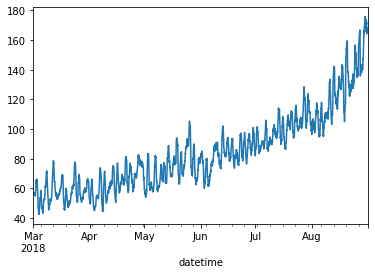

In [6]:
decomposed.trend.plot()

На графике видно, что с апреля по август заказы увеличиваются.

<AxesSubplot:xlabel='datetime'>

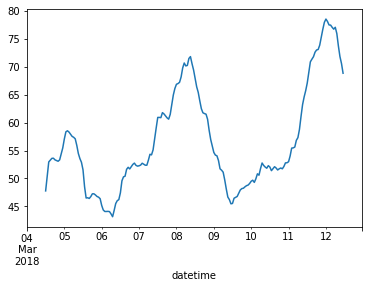

In [7]:
#посмотрим неделю в марте
decomposed_week_mar.trend.plot()

На графике с 5 по 11 марта 2018 г. мы видим, что большим спросом такси пользуются вначале недели (понедельник) и в середине(среда), малым спросом во вторник, субботу и в воскресение Возможно это связанно с тем, что в выходные у всех активный образ жизни: гуляют, катаются на велосипедах и т.д. А в понедельник некоторые просыпают на работу и пользуются такси.

<AxesSubplot:xlabel='datetime'>

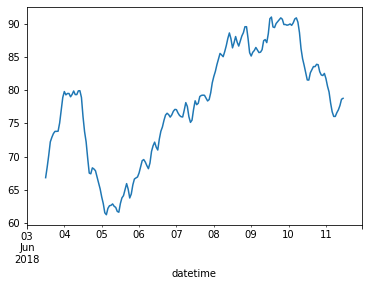

In [8]:
#посмотрим неделю в июне
decomposed_week_jun.trend.plot()

Тренд июня отличается с мартом, маленький спрос только во вторник.

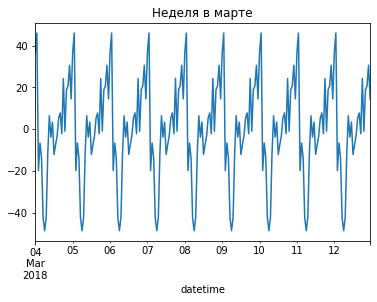

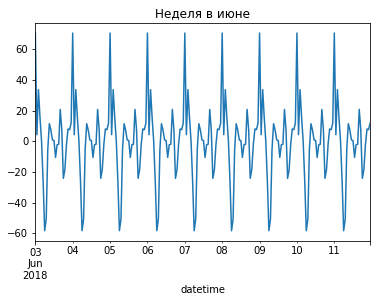

In [9]:
decomposed_week_mar.seasonal.plot()
plt.title('Неделя в марте')
plt.show()

decomposed_week_jun.seasonal.plot()
plt.title('Неделя в июне')
plt.show()

Сезонность одинаковая. Посмотрим сезонность за 2 дня.

<AxesSubplot:xlabel='datetime'>

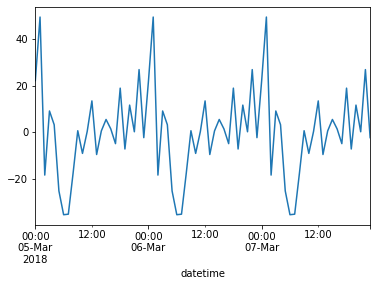

In [10]:
decomposed_day_mar = seasonal_decompose(taxi_res['2018-03-05':'2018-03-07'])
decomposed_day_mar.seasonal.plot()

На графике видно, что ночью спрос падает; с часов 7, 8 увеличивается и ближе к ночи достигает самых максимальных показателей.

Теперь посмотрим показатели по месяцам (апрель и август):

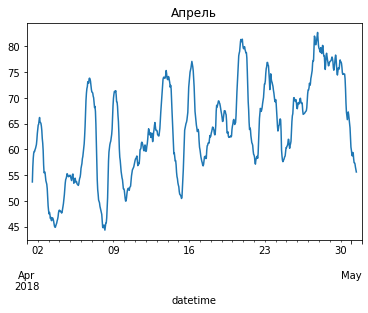

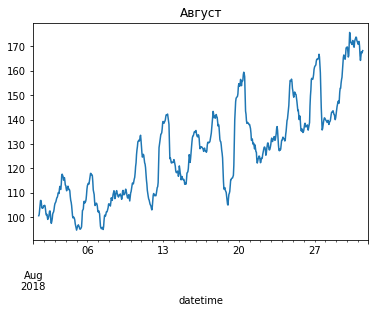

In [11]:
decomposed_month_apr.trend.plot()
plt.title('Апрель')
plt.show()
decomposed_month_aug.trend.plot()
plt.title('Август')
plt.show()

В обоих графиках с каждым днем увеличивается спрос на такси, но больше всего заказывают такси в августе, нежели весной. Летом все наслаждаются теплом и прогуливаются, а потом заказывают такси, если устали, до дома. 

Теперь создадим признаки для прогнозирования. В нашем случае это будет часы и дни недели. Так же получим отстающие значения и вычислим скользящее среднее.

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [13]:
make_features(taxi_res, 2, 24)
taxi_res.head()

,num_orders,hour,dayofweek,lag_1,lag_2,rolling_mean
datetime,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN
2018-03-01 02:00:00,71,2,3,85.0,124.0,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,NaN
2018-03-01 04:00:00,43,4,3,66.0,71.0,NaN


## Обучение моделей

Рассмотрим 3 модели:
    
    - LinearRegression;
    - CatBoost;
    - LightGBM.
    
Но вначале разобьем данные на выборки.

In [14]:
train, test = train_test_split(taxi_res, shuffle=False, test_size=0.1)
train = train.dropna()

In [15]:
train_features = train.drop(['num_orders'], axis=1)
train_target = train['num_orders']
test_features = test.drop(['num_orders'], axis=1)
test_target = test['num_orders']

### LinearRegression

In [16]:
mod_lr = LinearRegression()
mod_lr.fit(train_features, train_target)
pred = mod_lr.predict(test_features)
print('RMSE модели LinearRegression: ', mean_squared_error(test_target,pred) ** 0.5)

RMSE модели LinearRegression:  51.26866698864005


### CatBoost

In [17]:
train_dataset = cat.Pool(train_features, train_target)
test_dataset = cat.Pool(test_features, test_target)

In [18]:
modelCat = CatBoostRegressor(random_state = 12345, verbose=False)

param_search = {'depth' : [3, 5, 7],
                'learning_rate' : [0.01, 0.25, 0.5],
                'iterations' : [50, 100, 150]
               }

tscv = TimeSeriesSplit(n_splits=8)
gsearchCat = GridSearchCV(estimator=modelCat, cv=tscv,
                        param_grid=param_search, scoring = 'neg_mean_squared_error')
gsearchCat.fit(train_features, train_target)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=8),
             estimator=<catboost.core.CatBoostRegressor object at 0x7fe0b5e64a30>,
             param_grid={'depth': [3, 5, 7], 'iterations': [50, 100, 150],
                         'learning_rate': [0.01, 0.25, 0.5]},
             scoring='neg_mean_squared_error')

In [19]:
print('RMSE модели CatBoost: ', np.abs(gsearchCat.best_score_) ** 0.5)

RMSE модели CatBoost:  24.975614216952856


In [20]:
print('Лучшие параметры: ', gsearchCat.best_params_)

Лучшие параметры:  {'depth': 5, 'iterations': 50, 'learning_rate': 0.25}


### LightGBM

In [21]:
modelLight = LGBMRegressor(random_state = 42)
param_search = {'max_depth' : [20, 50], 'n_estimators' : [50, 100, 200],
               'learning_rate' : [0.1, 0.25, 0.5]
               }
tscv = TimeSeriesSplit(n_splits=8)
gsearchLight = GridSearchCV(estimator=modelLight, cv=tscv,
                        param_grid=param_search,scoring = 'neg_mean_squared_error')
gsearchLight.fit(train_features, train_target)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=8),
             estimator=LGBMRegressor(random_state=42),
             param_grid={'learning_rate': [0.1, 0.25, 0.5],
                         'max_depth': [20, 50],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

In [22]:
print('RMSE модели LightGBM: ',np.abs(gsearchLight.best_score_) ** 0.5)

RMSE модели LightGBM:  24.602224373554645


In [23]:
print('Лучшие параметры: ', gsearchLight.best_params_)

Лучшие параметры:  {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 50}


Вывод: 

    - модели обучены;
    - наилучшие гиперпараметры найдены;
    - подготовка к тестированию завершена.

## Тестирование

In [24]:
#CatBoostRegressor
mod_cat = CatBoostRegressor(depth = 7, iterations = 50, learning_rate = 0.25, loss_function = 'RMSE')
mod_cat.fit(train_dataset, eval_set = test_dataset, verbose = False)
pred_cat = mod_cat.predict(test_features)
print('RMSE модели CatBoost', mean_squared_error(test_target, pred_cat) ** 0.5)

RMSE модели CatBoost 47.397483916711245


In [25]:
#LGBMRegressor
mod_lgbm = LGBMRegressor(max_depth = 20, n_estimators = 50, learning_rate = 0.1, random_state = 42)
mod_lgbm.fit(train_features,train_target, eval_set = (test_features,test_target), eval_metric = 'RMSE', verbose = 10)

[10]	valid_0's rmse: 60.3708	valid_0's l2: 3644.64
[20]	valid_0's rmse: 51.9187	valid_0's l2: 2695.56
[30]	valid_0's rmse: 48.0113	valid_0's l2: 2305.09
[40]	valid_0's rmse: 45.5985	valid_0's l2: 2079.22
[50]	valid_0's rmse: 45.1579	valid_0's l2: 2039.24


LGBMRegressor(max_depth=20, n_estimators=50, random_state=42)

In [26]:
pred_lgbm = mod_lgbm.predict(test_features)
print('RMSE модели LGBM: ', mean_squared_error(test_target, pred_lgbm) ** 0.5)

RMSE модели LGBM:  45.157948385699804


Самая лучшая метрика у модели LGBMRegressor = 45.15 с параметрами max_depth = 20, n_estimators = 50, learning_rate = 0.1. Посмотрим целевой признак с предсказаниями на графике:

RMSE: 45.157948385699804


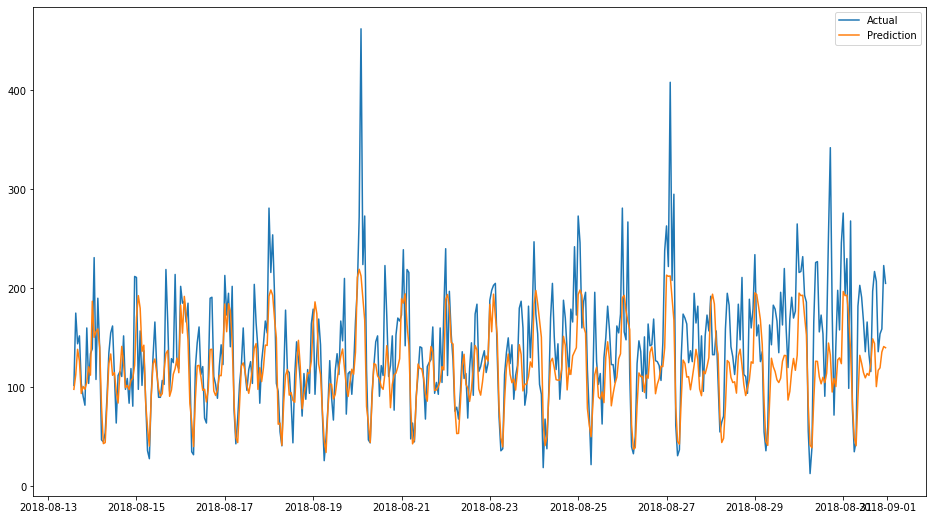

In [27]:
best_pred = mod_lgbm.predict(test_features)

print("RMSE:", mean_squared_error(test_target, best_pred) ** 0.5)
plt.figure(figsize=(16,9))
plt.plot(test_features.index, test_target, label='Actual')
plt.plot(test_features.index, best_pred, label='Prediction')
plt.legend()
plt.show()

На графике видно, что данная модель предсказывает данные с небольшими погрешностями, но в целом модель справилась неплохо. Цель достигнута, метрика RMSE не больше 48.